# COGS 108 - EDA Checkpoint

# Names

- Joonsung Park
- James Chung
- Richard Gross
- Madison Hambly
- Colin Lintereur

<a id='research_question'></a>
# Research Question

How do the most popular topics from previous COGS 108 final projects vary per quarter from 2019 to 2021? Also what other trends can we find in past submissions, like changes in word count, and number of graphs used?

# Setup

In [2]:
# importing libraries
import numpy as np
import json
import zipfile
import pandas as pd
import re
import seaborn as sns
import glob
import requests

import pandas as pd
import glob as glob
import seaborn as sns
sns.set(font_scale=1, style="white")

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

plt.rcParams['figure.figsize'] = (20, 10)

# copy/paste API key for uClassify
API_KEY = 'sWUDzzmKJCId'

We now search through the zip file of a quarter we want to study. We can get the quarter/group/year information from the file names. We get the research question by looking for the "Research Question" (or some similar) header and getting the text after it.

We manually ran this code for each project repo/zip. 

In [3]:
# initializing lists
research_questions = {}
qtr = []
year = []
group = []
# special projects are marked with '_S' at the end of its name
special = []
word_counts = []
index = 0

# a magic number to guess if this string is the research question
# (minimum character length)
MIN_RQ_LEN = 30

# reading zip file for a certain quarter
with zipfile.ZipFile("zips/FinalProjects-Fa20-main.zip", "r") as f:
    for i, name in enumerate(f.namelist()):
        # skip files that are not jupyter notebooks
        if '.ipynb' not in name:
            continue
        rf = json.loads(f.read(name))
        word_count = 0
        rq_found = False
        rq_in_header = False
        
        # loop through every cell
        for j, cell in enumerate(rf['cells']):
            if cell['cell_type'] == 'markdown':
                # for the cell with the rq header, source_len > 1
                # means the question is also in this cell
                source_len = len(cell['source'])
                for c in cell['source']:
                    # if cell contains the research question header, update lists and extract the research question from the next cell
                    if (rq_found == False) and (rq_in_header == True or re.search(r"(^#.*research question)", c.lower()) != None):
                        # some other string in the cell's source list should be the question
                        if source_len > 1 and rq_in_header == False:
                            rq_in_header = True
                            continue

                        # if there is more text after the header, question may be in THIS cell
                        if rq_in_header == True:
                            # ignore '\n' string or any string that is probably not the rq
                            if len(c.lstrip()) < MIN_RQ_LEN:
                                continue
                            rq = str(c)
                            rq_in_header = False
                        # get the research question from the cell AFTER the cell that contains the header 'Research Question'
                        else:
                            rq = ' '.join(rf['cells'][j+1]['source'])
                        # remove pesky html tags for API to handle correctly
                        rq = re.sub('<[^<]+?>', '', rq)
                        
                        # extract quarter info from repo name
                        date = re.search(r"-(.*)-", name).group(1)
                        qtr.append(date[:2].upper())
                        year.append(int(date[2:]))

                        # extract group number
                        fname = re.search(r"/.*", name).group(0)
                        group.append(int(re.search(r"[$0-9^]{2,3}", fname)[0]))

                        special.append(False if re.search(r"_S\.ipynb", name) == None else True)
                        
                        research_questions[str(group[index])+"_"+qtr[index]+"_"+str(year[index])] = rq          
                        rq_found = True
                        index += 1
                    word_count += len(c.replace('#', '').lstrip().split(' '))
        if rq_found:
            word_counts.append(word_count)

After collecting all the data we need from the submissions, we can use a text classifier to find the general topic of the submission. We are currently using an API made by uClassify to do this classification for us. See [here](https://www.uclassify.com/browse/uclassify/iab-taxonomy-v2?input=Text) for details on the API we are using.

In [3]:
# initialize topics list
topic = []

# loop through research questions and find the most confident topic class from topic classifier
for i, (g, q, y) in enumerate(zip(group, qtr, year)):
    text = research_questions[str(group[i])+"_"+qtr[i]+"_"+str(year[i])]

    # conform to latin-1 encoding for API
    text = text.encode('latin-1', 'replace').decode('latin-1')
    # don't allow literal quotes and remove unknown symbols
    text = text.replace('\"', '').replace('?', '')
    
    # get the Response object
    response = requests.post('https://api.uclassify.com/v1/uclassify/iab-taxonomy-v2/classify',
        data = "{\"texts\":[\"" + text + "\"]}",
        headers = {'Authorization': 'Token ' + API_KEY})

    closest_topic = ''
    max_p = 0
    # find the highest predicted topic
    for t in response.json()[0]['classification']:
        if t['p'] > max_p:
            closest_topic = t['className']
            max_p = t['p']
    topic.append(closest_topic)
    if i == 0:
        print("EXAMPLE:\n", research_questions[str(group[i])+"_"+qtr[i]+"_"+str(year[i])], " :: ", topic[i])

EXAMPLE:
 In the past 60 years, has rap become less lyric-centric and/or disconnected from societal issues as a result of consistently poor lyric choices? Can we form the conclusion that the main topics in rap _have_ changed after performing an analysis of the Billboard's number-one rap singles for each decade ranging from the 1960s to the 2010s?  ::  music and audio_reggae_15_28


Now that we have stored the topics of the submissions, we can run a sanity check to make sure that all of our list are the same length and then export the data to a csv file.

In [4]:
# double check that all the lists are the same length
print(len(group), len(qtr), len(year), len(topic), len(special), len(word_counts))

# generate data frame and output it to a csv file
d = {'Group':group, 'Quarter':qtr, 'Year':year, 'Topic':topic, 'Special':special, 'Word_Count':word_counts}
df = pd.DataFrame(data = d)
output = df.to_csv(path_or_buf="./csvs/"+qtr[0] + "20" + str(year[0])+".csv")

NameError: name 'topic' is not defined

# Data Cleaning

Since we are collecting the data ourselves, there is not much work to be done cleaning the data after collecting all of the csv files for each quarter and merging them together into one large dataset. One column we do need to remove however is a column named 'Unnamed: 0'. This column is an artifact of reading csv files that store index information for each dataset. This column is redundant in our new dataset so we can remove it.

In [5]:
# using glob to get all csvs
files = glob.glob('./csvs/*.csv')
df_total = pd.DataFrame()
entries = 0

# read all csvs to dataframes and combine into one df
for f_name in files:
    csv = pd.read_csv(f_name)
    csv['Topic'] = csv['Topic'].apply(lambda t: t.split('_')[0])
    df_total = df_total.append(csv)
    entries = entries + len(csv.index)

# remove artifact 'Unnamed'
df_total = df_total.drop('Unnamed: 0', axis=1)

assert(len(df_total.index) == entries)
print('Observations: ' + str(len(df_total.index)))
df_total.head()

Observations: 364


,Group,Quarter,Year,Topic,Special,Word_Count
0,1,FA,20,music and audio,False,6999
1,2,FA,20,automotive,False,8686
2,4,FA,20,video gaming,False,1864
3,5,FA,20,sports,False,5483
4,6,FA,20,pets,False,4595


In [6]:
df_total

,Group,Quarter,Year,Topic,Special,Word_Count
0,1,FA,20,music and audio,False,6999
1,2,FA,20,automotive,False,8686
2,4,FA,20,video gaming,False,1864
3,5,FA,20,sports,False,5483
4,6,FA,20,pets,False,4595
...,...,...,...,...,...,...
60,87,WI,2021,HEALTHY LIVING,False,2637
61,88,WI,2021,IMPACT,False,3538
62,89,WI,2021,POLITICS,False,4755
63,90,WI,2021,POLITICS,False,3298


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

<AxesSubplot:xlabel='Topic', ylabel='Word_Count'>

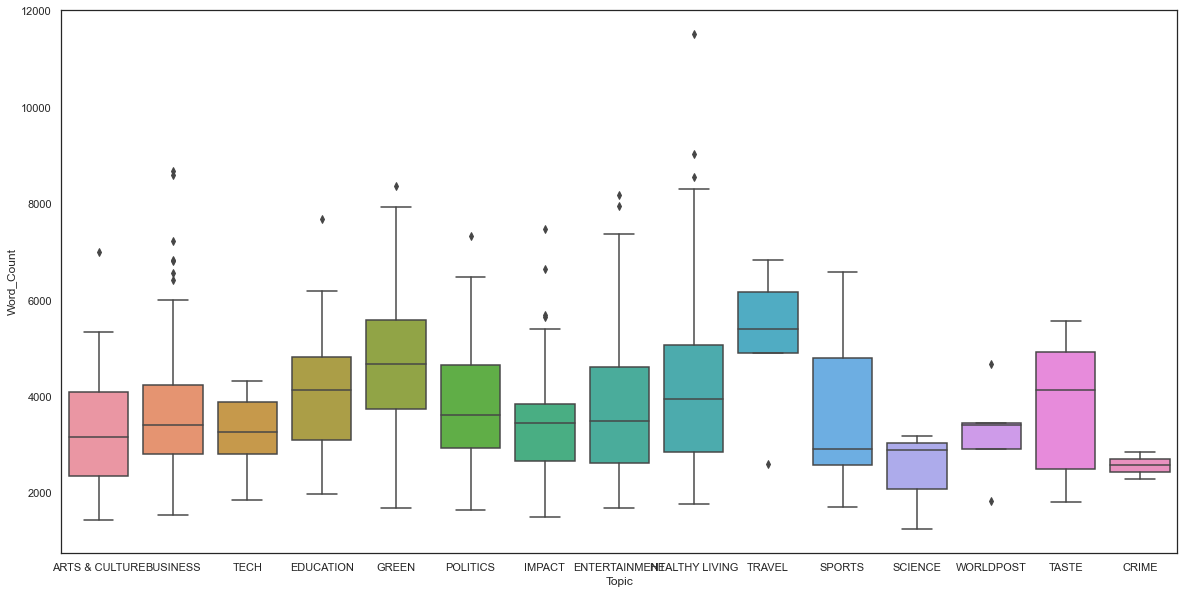

In [56]:
#wordcount boxplot per topic

df = df_total
sns.boxplot(x='Topic', y='Word_Count', data=df)

<AxesSubplot:xlabel='count', ylabel='Topic'>

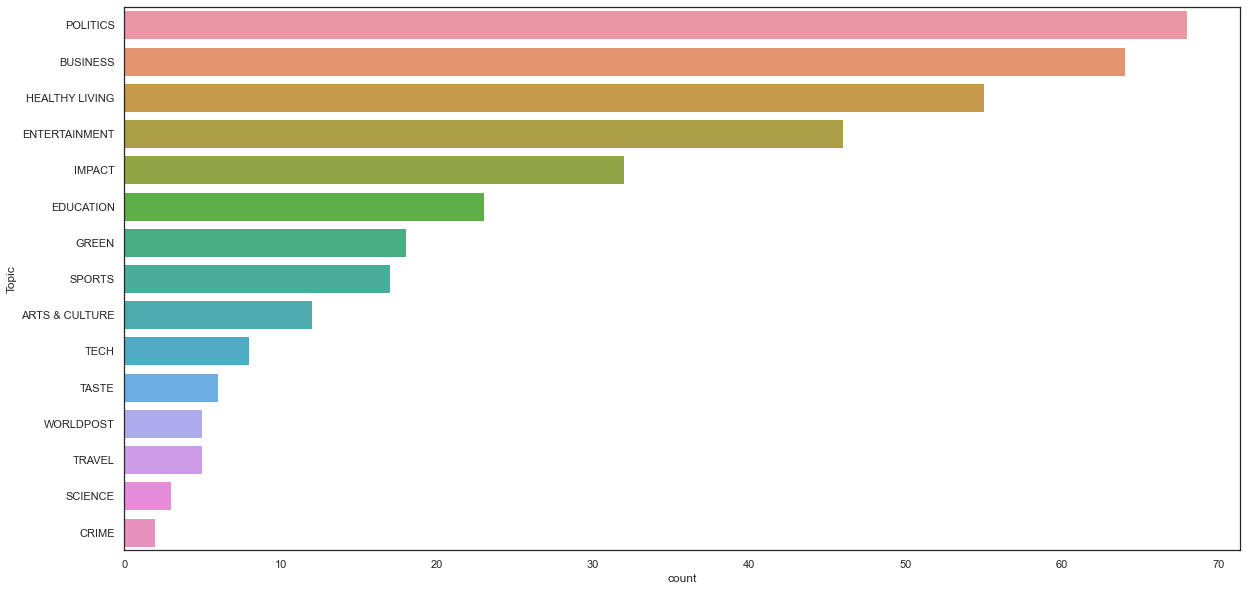

In [46]:
#Total amount of each topic

sns.countplot(y='Topic',data=df, order=df['Topic'].value_counts().index)

<AxesSubplot:xlabel='Topic', ylabel='count'>

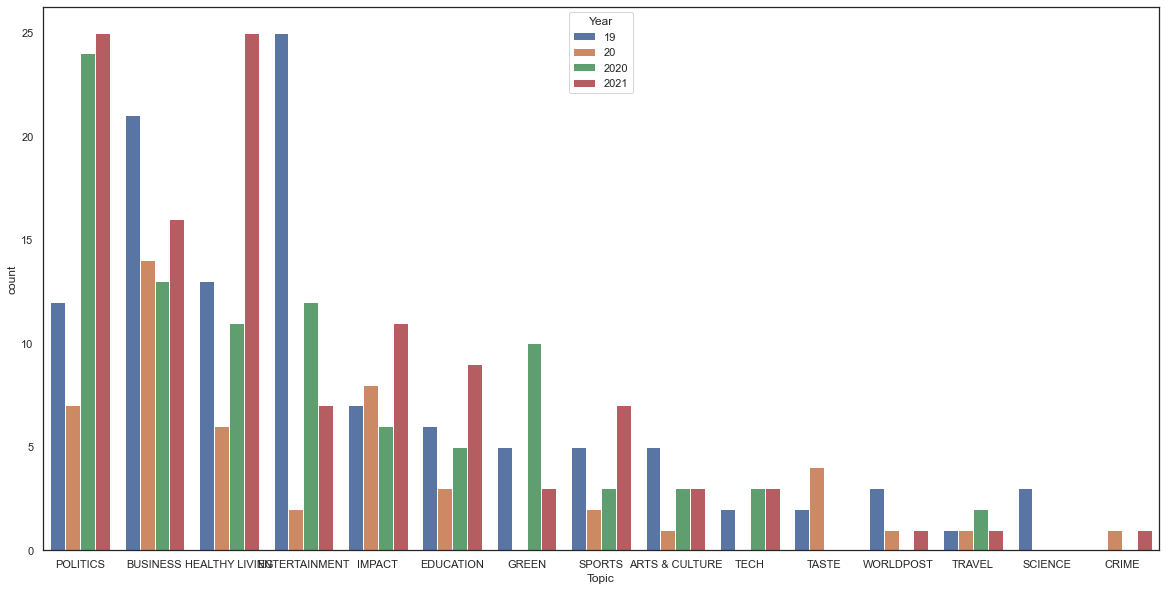

In [55]:
sns.countplot(x='Topic',data=df, hue='Year', order=df['Topic'].value_counts().index)

In [76]:
#Add chronological order to rows
chronological = []
#starting from spring 19 as 0, and incrementing, so that fall 19 is 1, winter 20 is 2
#spring 19: 0
#fall 19: 1
#winter 20: 2
#spring 20: 3
#fall 20: 4
#winter 21: 5
#

for index, row in df.iterrows():
    print(row['Quarter'], row['Year'])
    #if(row['Quarter'] == "SP"):
    #   print(row['Year'])

FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
FA 2020
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP 19
SP